In [15]:
%matplotlib inline

import os
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

from neuronunit.neuroelectro import NeuroElectroSummary

In [2]:
# Allen SDK API
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.ephys.extract_cell_features import get_square_stim_characteristics,\
                                                 get_sweep_from_nwb

#### Get some cell and sweep metadata

In [3]:
dataset_id = 354190013  # Internal ID that AIBS uses for a particular Scnn1a-Tg2-Cre 
                        # Primary visual area, layer 5 neuron.
ct = CellTypesApi()
cmd = ct.get_cell(dataset_id) # Cell metadata

In [4]:
# Print some summary metadata for the cell
print(('Cell name: %s\n' 
       'Cell ID: %s\n'
       'Brain region: %s' % (cmd['name'],cmd['id'],cmd['structure']['name'])))

Cell name: Scnn1a-Tg2-Cre;Ai14(IVSCC)-176962.05.01.01
Cell ID: 354190013
Brain region: Primary visual area, layer 5


In [5]:
experiment_params = ct.get_ephys_sweeps(dataset_id)
matching_sweeps = {} # Many sweeps are likely to have the desired parameters.  
for sp in experiment_params:
    if sp['stimulus_name']=='Long Square' and sp['num_spikes']>0:
        # Add sweeps with a long square pulse and spikes
        matching_sweeps[sp['sweep_number']] = sp 

# The sweep number of the first such sweep
sweep_num = sorted(list(matching_sweeps.keys()))[0]
pprint(matching_sweeps[sweep_num]) # Print sweep details

{'bridge_balance_mohm': 18.9255180358887,
 'id': 396427442,
 'leak_pa': 0.0,
 'num_spikes': 1,
 'peak_deflection': 0.0,
 'post_noise_rms_mv': 0.0379615686833858,
 'post_vm_mv': -73.3877792358398,
 'pre_noise_rms_mv': 0.0390412472188473,
 'pre_vm_mv': -73.2384948730469,
 'slow_noise_rms_mv': 0.144496634602547,
 'slow_vm_mv': -73.2384948730469,
 'specimen_id': 354190013,
 'stimulus_absolute_amplitude': 129.99999687846,
 'stimulus_description': 'C1LSCOARSE150216[12]',
 'stimulus_duration': 0.999995,
 'stimulus_interval': 0.0,
 'stimulus_name': 'Long Square',
 'stimulus_relative_amplitude': 1.0,
 'stimulus_start_time': 0.92,
 'stimulus_units': 'pA',
 'sweep_number': 46,
 'vm_delta_mv': 0.149284362792969}


#### Extract and plot some traces

In [6]:
# Download and the electrophysiology data for one cell, if it is not already downloaded
raw_ephys_file_name = '%d_raw_data.nwb' % dataset_id
if not os.path.isfile(raw_ephys_file_name):
    ct.save_ephys_data(dataset_id, raw_ephys_file_name)

In [7]:
# Extract the stimulus parameters for this sweep
vm, im, t = get_sweep_from_nwb('%d_raw_data.nwb' % dataset_id, sweep_num)
sweep_info = {}
sweep_info['stim_start'], sweep_info['stim_dur'], sweep_info['stim_amp'], start_idx, end_idx \
= get_square_stim_characteristics(im, t)
pprint(sweep_info)

{'stim_amp': 130.0, 'stim_dur': 1.0, 'stim_start': 1.02}


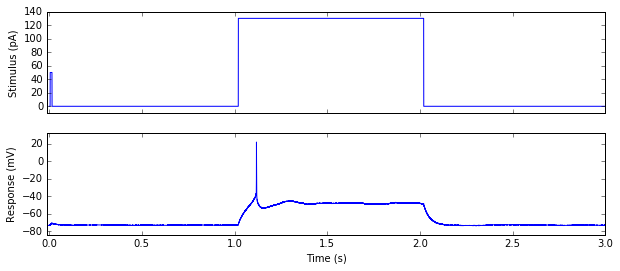

In [8]:
# Plot the stimulus and the response for this sweep
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,4))
for i,(y,label) in enumerate([(im,"Stimulus (pA)"),(vm,"Response (mV)"),]):
    ax[i].plot(t,y)
    ax[i].set_xlim(-0.01,3)
    if i:
        ax[i].set_xlabel("Time (s)")
    ax[i].set_ylim(y.min()-10,y.max()+10)
    ax[i].set_ylabel(label)

####Does the spike peak of this sweep match with the AIBS pre-calculated value?

In [9]:
# AIBS computed peak for this sweep.
aibs_ap_peak_v = cmd['ephys_features'][0]['peak_v_long_square']
print("AIBS computed spike peak = %.1f mV" % aibs_ap_peak_v)

AIBS computed spike peak = 22.0 mV


In [10]:
# Calculate the voltage at the spike peak for this sweep.  
our_ap_peak_v = np.max(vm) # really simple way to get the voltage of the spike peak
our_ap_peak_index = np.argmax(vm)
our_ap_peak_t = t[our_ap_peak_index]
print("Our sweep's spike peak = %.1f mV" % our_ap_peak_v)

Our sweep's spike peak = 22.0 mV


####Does the rheobase for this experiment match with the AIBS pre-calculated value?

In [11]:
# The AIBS value.  
rheobase_sweep_id = cmd['ephys_features'][0]['rheobase_sweep_id']
for sp in experiment_params:
    if sp['id']==rheobase_sweep_id:
        sweep_num = sp['sweep_number']
        break

print("AIBS calculated rheobase was %.1f pA" % sp['stimulus_absolute_amplitude'])

AIBS calculated rheobase was 130.0 pA


In [12]:
# Our value.  
sweeps_nums_with_one_spike = []
smallest_pulse_size = np.inf
for sp in experiment_params:
    if sp['stimulus_name']=='Long Square' and sp['num_spikes']==1:
        sweeps_nums_with_one_spike.append(sp['sweep_number'])
        pulse_size = sp['stimulus_absolute_amplitude']
        if pulse_size < smallest_pulse_size:
            smallest_pulse_size = pulse_size
print("Our rheobase is %.1f pA" % smallest_pulse_size)

Our rheobase is 130.0 pA


####Compare with NeuroElectro

In [14]:
# Continue with other ephys parameters
params = [('Spike Peak', 'peak_v_long_square', 'mV'), # Neuroelectro name, AIBS name. 
          ('Spike Threshold', 'threshold_v_long_square', 'mV'),
          ('Input Resistance', 'input_resistance_mohm', 'MOhm')]

for ne_name,aibs_name,units in params:
    nes = NeuroElectroSummary(neuron={'name':'Neocortex Pyramidal Cell Layer 5-6'},
                              ephysprop={'name':ne_name})
    ne = nes.get_values(quiet=True)
    ne_value = '%.1f %s +/- %.1f %s' % (ne['value_mean'],units,ne['value_sd'],units)
    
    aibs_value = '%.1f %s' % (cmd['ephys_features'][0][aibs_name],units)
    
    print('%s: NEUROELECTRO %s; AIBS %s' % (ne_name,ne_value,aibs_value))

Spike Peak: NEUROELECTRO 50.4 mV +/- 0.0 mV; AIBS 22.0 mV
Spike Threshold: NEUROELECTRO -39.9 mV +/- 6.8 mV; AIBS -34.4 mV
Input Resistance: NEUROELECTRO 95.9 MOhm +/- 56.9 MOhm; AIBS 116.1 MOhm


<hr>

##Test Construction

In [17]:
np.inf == np.inf

True